# Feature Engineering & Model's

## Libraries

In [89]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import itertools


## Global Variables

In [90]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global Functions

In [91]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Import data

In [92]:
df = polars_read_excel(PATH_DATAFRAME)

Could not determine dtype for column 20, falling back to string
Could not determine dtype for column 21, falling back to string
Could not determine dtype for column 22, falling back to string
Could not determine dtype for column 23, falling back to string
Could not determine dtype for column 24, falling back to string


In [93]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

## Data Manipulation

In [94]:


 # #df_engineered = (
        #     df # Start with the full DataFrame loaded from full_join.xlsx
        #     .filter(pl.col("PackagesHandled") > 0)
        #     .filter(pl.col("PackagingQuality").is_in(["Bad", "Good"]))
        #     .with_columns([
        #         # Enhanced Date Features
        #         pl.col("DateOfReport").dt.ordinal_day().alias("report_day_of_year"),
        #         pl.col("DateOfReport").dt.week().alias("report_week_of_year"),
        #         pl.col("DateOfReport").dt.quarter().alias("report_quarter"),
        #         pl.when(pl.col("DateOfReport").dt.weekday().is_in([6, 7])) # Polars: Mon=1..Sun=7
        #             .then(1).otherwise(0).alias("is_weekend").cast(pl.Int8),
        # 
        #         (np.sin(2 * np.pi * pl.col("DateOfReport").dt.month() / 12)).alias('month_sin'),
        #         (np.cos(2 * np.pi * pl.col("DateOfReport").dt.month() / 12)).alias('month_cos'),
        #         (np.sin(2 * np.pi * (pl.col("DateOfReport").dt.weekday() - 1) / 7)).alias('weekday_sin'),
        #         (np.cos(2 * np.pi * (pl.col("DateOfReport").dt.weekday() - 1) / 7)).alias('weekday_cos'),
        # 
        # # Your original calculated ratios
        #         (pl.col("TotalIncidents") / pl.col("PackagesHandled")).alias("TotalIncidents (%)"),
        #         (pl.col("AnomaliesDetected") / pl.col("PackagesHandled")).alias("AnomaliesDetected (%)"),
        # 
        # 
        #     ])
        #     .sort("DateOfReport")
        # )
        # 
        # # Define df_input by selecting ALL columns you want for your model's features + target
        # #df_input = df_engineered.select([
        #     # --- New Date Features ---
        #     pl.col("DateOfReport").dt.day().alias("report_day_num"), # Keeping original day number
        #     "month_sin",
        #     "month_cos",
        #     "weekday_sin",
        #     "weekday_cos",
        #     "report_day_of_year",
        #     "report_week_of_year",
        #     "report_quarter",
        #     "is_weekend",
        # 
        #     # --- Original Categorical/Numerical Features from your initial select ---
        #     # (Excluding original simple Month, Day, Weekday if replaced by engineered versions)
        #     "SupplierName",
        #     "GarmentType",
        #     "Material",
        #     "Weight", 
        #     "ProposedUnitsPerCarton",
        #     "ProposedFoldingMethod",
        #     "ProposedLayout",
        #     "Size",
        #     "Collection",
        #     # "PreviousMonth", # Decide if/how to include this. If as string, add to categorical_features later.
        # 
        # 
        #     # --- Your Calculated Ratios ---
        #     "TotalIncidents (%)",
        #     "AnomaliesDetected (%)",
        # 
        #     # --- Scorecard Features ---
        #     "BadPackagingRate (%)",
        #     "OnTimeDeliveryRate (%)",
        #     "AverageCostPerIncident (€)",
        # 
        #     # --- Target Variable ---
        #     "PackagingQuality"
        # ])
        # 

In [95]:
# Filter out "Uncertain" from the original PackagingQuality
df = df.filter(pl.col("PackagingQuality") != "Uncertain")

# Create HasLinkedFutureIncident flag
linked_incident_id_col_in_df = "IncidentID_AutoGen" # Or "IncidentID_AutoGen_right", etc.

if linked_incident_id_col_in_df not in df.columns:
    print(f"Warning: Column '{linked_incident_id_col_in_df}' for linked future incident not found. 'HasLinkedFutureIncident' will be all False.")
    df = df.with_columns(pl.lit(False).alias("HasLinkedFutureIncident"))
else:
    df = df.with_columns(
        pl.col(linked_incident_id_col_in_df).is_not_null().alias("HasLinkedFutureIncident")
    )

# Create the refined target variable Y_Refined_PackagingIssue
df = df.with_columns(
    pl.when( (pl.col("PackagingQuality") == "Bad") | (pl.col("HasLinkedFutureIncident") == True) )
      .then(pl.lit(1)) # Problematic
      .otherwise(pl.lit(0)) # Not Problematic
      .alias("Y_Refined_PackagingIssue")
)

In [96]:
df_input = (
    df 
    .sort("DateOfReport")
    .select([
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        "PackagesHandled",             
        "TotalIncidents",             
        "AnomaliesDetected",          
        "BadPackagingRate (%)",        
        "OnTimeDeliveryRate (%)",      
        "AverageCostPerIncident (€)",  
        "Y_Refined_PackagingIssue",
    ])
)

### Target Variable

In [97]:
# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Encode target variable
#df_pd["PackagingQuality"] = df_pd["PackagingQuality"].map({"Good": 1, "Bad": 0})

# Define features and target
X = df_pd.drop(columns=["Y_Refined_PackagingIssue"])
y = df_pd["Y_Refined_PackagingIssue"]

In [98]:
### Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

### Split dataset

In [99]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

## XGBoost

In [100]:
# Do this for both X_train and X_test
for col in categorical_features:
    if col in X_train.columns: # Check if column exists
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# Define weights
class_weights = np.where(y_train == 1, 1, 4)  # Adjust the weight for the minority class

# Instantiate the XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',  
    use_label_encoder=False,
    enable_categorical=True,
    tree_method='hist',
    n_estimators=1000, 
    learning_rate=0.05,
    random_state=42
)

# Train the model
model.fit(X_train, y_train, sample_weight=class_weights)

# Make predictions on the test set
y_pred_xgb = model.predict(X_test) 
y_proba_xgb = model.predict_proba(X_test)[:, 1] 

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### Evaluation

In [101]:
# Summary report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88    112468
           1       0.48      0.00      0.00     29709

    accuracy                           0.79    142177
   macro avg       0.64      0.50      0.44    142177
weighted avg       0.73      0.79      0.70    142177



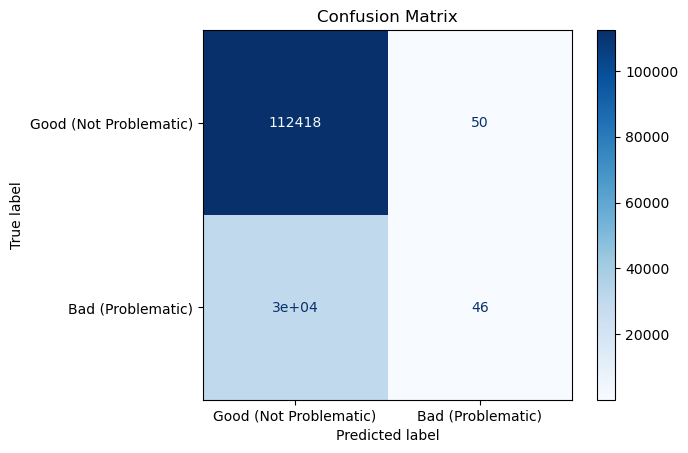

In [102]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (Not Problematic)", "Bad (Problematic)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6798


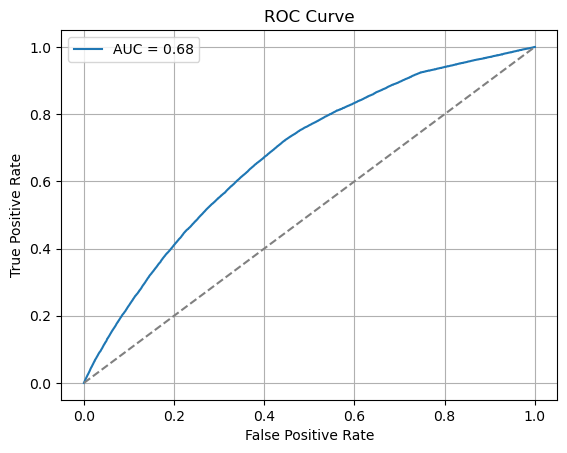

In [103]:
# Get predicted probabilities for the positive class ("Good" = 1)
y_proba = model.predict_proba(X_test)[:, 1]

# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
0,SupplierName,0.579556
2,Material,0.080560
1,GarmentType,0.027516
3,Weight,0.027360
14,AverageCostPerIncident (€),0.026828
12,BadPackagingRate (%),0.026644
7,Size,0.026566
5,ProposedFoldingMethod,0.026517
11,AnomaliesDetected,0.026335
10,TotalIncidents,0.026317


## LightGBM

In [105]:
#weights
class_weights = np.where(y_train == 1, 1, 4)  


# Instantiate the LightGBM classifier
model_lgb = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

actual_categorical_in_train = [col for col in categorical_features if col in X_train.columns and X_train[col].dtype.name == 'category']

# Train the model
model_lgb.fit(X_train, y_train, sample_weight=class_weights,categorical_feature=actual_categorical_in_train)
# Make predictions on the test set
y_pred_lgb = model_lgb.predict(X_test)
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69322, number of negative: 262424
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 331746, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061949 -> initscore=-2.717494
[LightGBM] [Info] Start training from score -2.717494


### Evaluation

In [106]:
#summary report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88    112468
           1       0.48      0.00      0.00     29709

    accuracy                           0.79    142177
   macro avg       0.64      0.50      0.44    142177
weighted avg       0.73      0.79      0.70    142177



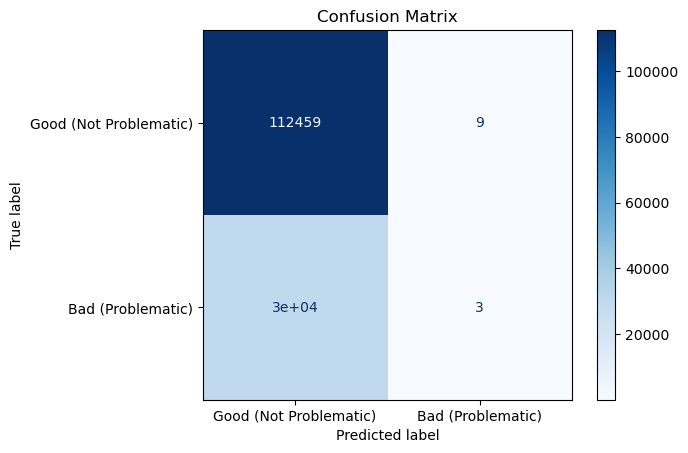

In [107]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (Not Problematic)", "Bad (Problematic)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6798


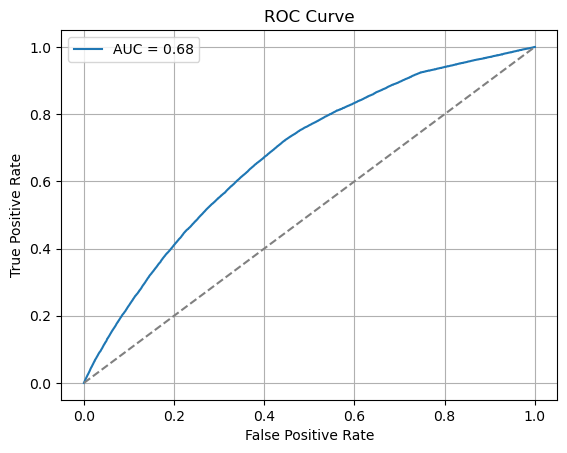

In [108]:
# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [109]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model_lgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
3,Weight,6632
4,ProposedUnitsPerCarton,5145
14,AverageCostPerIncident (€),2463
9,PackagesHandled,2065
13,OnTimeDeliveryRate (%),1950
10,TotalIncidents,1941
12,BadPackagingRate (%),1697
5,ProposedFoldingMethod,1696
11,AnomaliesDetected,1579
1,GarmentType,1208
